In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

import os
import glob

In [2]:
data_dir = '../input/optiver-realized-volatility-prediction/'

# 前処理に使う関数

In [3]:
# 加重平均価格
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

In [4]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [5]:
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

In [6]:
def count_unique(series):
    return len(np.unique(series))

In [7]:
book_train = pd.read_parquet(data_dir + "book_train.parquet/stock_id=15")
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,0.999519,0.999839,0.999454,0.999904,2,166,2,12
1,5,1,0.999711,1.000225,0.999647,1.000289,100,20,100,20
2,5,2,0.999775,1.000225,0.999711,1.000289,1,20,400,20
3,5,3,0.999839,1.000225,0.999775,1.000289,100,20,1,20
4,5,4,0.999839,1.000225,0.999711,1.000289,1,20,400,20


# book data 前処理

In [8]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)

    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    create_feature_dict = {
        'log_return':[realized_volatility, np.mean, np.std, np.sum],
        'log_return2':[realized_volatility, np.mean, np.std, np.sum],
        'wap_balance':[np.mean, np.std, np.sum],
        'price_spread':[np.mean, np.std, np.sum],
        'bid_spread':[np.mean, np.std, np.sum],
        'ask_spread':[np.mean, np.std, np.sum],
        'volume_imbalance':[np.mean, np.std, np.sum],
        'total_volume':[np.mean, np.std, np.sum],
        'wap':[np.mean, np.std, np.sum],
    }
    
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]
    
    last_seconds = [100, 150, 200, 250, 300, 350, 400, 450, 500]
    
    for second in last_seconds:
        second = 600 - second
        
        df_feature_sec = pd.DataFrame(df[df['seconds_in_bucket'] >= second].groupby('time_id').agg(create_feature_dict)).reset_index()
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature, df_feature_sec, how='left', left_on='time_id_', right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'], axis=1)
        
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'], axis=1)

    return df_feature

In [9]:
%%time
file_path = data_dir + "book_train.parquet/stock_id=0"
preprocessor_book(file_path)

CPU times: user 12.6 s, sys: 86.4 ms, total: 12.7 s
Wall time: 12.6 s


,log_return_realized_volatility,log_return_mean,log_return_std,log_return_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return2_sum,wap_balance_mean,wap_balance_std,wap_balance_sum,price_spread_mean,price_spread_std,price_spread_sum,bid_spread_mean,bid_spread_std,bid_spread_sum,ask_spread_mean,ask_spread_std,ask_spread_sum,volume_imbalance_mean,volume_imbalance_std,volume_imbalance_sum,total_volume_mean,total_volume_std,total_volume_sum,wap_mean,wap_std,wap_sum,log_return_realized_volatility_500,log_return_mean_500,log_return_std_500,log_return_sum_500,log_return2_realized_volatility_500,log_return2_mean_500,log_return2_std_500,log_return2_sum_500,wap_balance_mean_500,wap_balance_std_500,wap_balance_sum_500,price_spread_mean_500,price_spread_std_500,price_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,bid_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,ask_spread_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,volume_imbalance_sum_500,total_volume_mean_500,total_volume_std_500,total_volume_sum_500,wap_mean_500,wap_std_500,wap_sum_500,log_return_realized_volatility_450,log_return_mean_450,log_return_std_450,log_return_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return2_sum_450,wap_balance_mean_450,wap_balance_std_450,wap_balance_sum_450,price_spread_mean_450,price_spread_std_450,price_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,bid_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,ask_spread_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,volume_imbalance_sum_450,total_volume_mean_450,total_volume_std_450,total_volume_sum_450,wap_mean_450,wap_std_450,wap_sum_450,log_return_realized_volatility_400,log_return_mean_400,log_return_std_400,log_return_sum_400,log_return2_realized_volatility_400,log_return2_mean_400,log_return2_std_400,log_return2_sum_400,wap_balance_mean_400,wap_balance_std_400,wap_balance_sum_400,price_spread_mean_400,price_spread_std_400,price_spread_sum_400,bid_spread_mean_400,bid_spread_std_400,bid_spread_sum_400,ask_spread_mean_400,ask_spread_std_400,ask_spread_sum_400,volume_imbalance_mean_400,volume_imbalance_std_400,volume_imbalance_sum_400,total_volume_mean_400,total_volume_std_400,total_volume_sum_400,wap_mean_400,wap_std_400,wap_sum_400,log_return_realized_volatility_350,log_return_mean_350,log_return_std_350,log_return_sum_350,log_return2_realized_volatility_350,log_return2_mean_350,log_return2_std_350,log_return2_sum_350,wap_balance_mean_350,wap_balance_std_350,wap_balance_sum_350,price_spread_mean_350,price_spread_std_350,price_spread_sum_350,bid_spread_mean_350,bid_spread_std_350,bid_spread_sum_350,ask_spread_mean_350,ask_spread_std_350,ask_spread_sum_350,volume_imbalance_mean_350,volume_imbalance_std_350,volume_imbalance_sum_350,total_volume_mean_350,total_volume_std_350,total_volume_sum_350,wap_mean_350,wap_std_350,wap_sum_350,log_return_realized_volatility_300,log_return_mean_300,log_return_std_300,log_return_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,log_return2_sum_300,wap_balance_mean_300,wap_balance_std_300,wap_balance_sum_300,price_spread_mean_300,price_spread_std_300,price_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,bid_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,ask_spread_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,volume_imbalance_sum_300,total_volume_mean_300,total_volume_std_300,total_volume_sum_300,wap_mean_300,wap_std_300,wap_sum_300,log_return_realized_volatility_250,log_return_mean_250,log_return_std_250,log_return_sum_250,log_return2_realized_volatility_250,log_return2_mean_250,log_return2_std_250,log_return2_sum_250,wap_balance_mean_250,wap_balance_std_250,wap_balance_sum_250,price_spread_mean_250,price_spread_std_250,price_spread_sum_250,bid_spread_mean_250,bid_spread_std_250,bid_spread_sum_250,ask_spread_mean_250,ask_spread_std_250,ask_spread_sum_250,volume_imbalance_mean_250,volume_imb

In [10]:
trade_train = pd.read_parquet(data_dir + "trade_train.parquet/stock_id=0")
trade_train.head(15)

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
5,5,78,1.003762,134,5
6,5,122,1.004207,102,3
7,5,127,1.004577,1,1
8,5,144,1.004370,6,1
9,5,147,1.003964,233,4


# trade data 前処理

In [11]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]
    
    last_seconds = [100, 150, 200, 250, 300, 350, 400, 450, 500]
    
    for second in last_seconds:
        second = 600 - second
        
        df_feature_sec = pd.DataFrame(df[df['seconds_in_bucket'] >= second].groupby('time_id').agg(aggregate_dictionary)).reset_index()
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature, df_feature_sec, how='left', left_on='time_id_', right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'], axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'], axis=1)
    
    return df_feature

In [12]:
%%time
file_path = data_dir + "trade_train.parquet/stock_id=0"
preprocessor_trade(file_path)

CPU times: user 5.89 s, sys: 40.7 ms, total: 5.93 s
Wall time: 6.05 s


,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_500,trade_seconds_in_bucket_count_unique_500,trade_size_sum_500,trade_order_count_mean_500,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_mean_400,trade_log_return_realized_volatility_350,trade_seconds_in_bucket_count_unique_350,trade_size_sum_350,trade_order_count_mean_350,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_250,trade_seconds_in_bucket_count_unique_250,trade_size_sum_250,trade_order_count_mean_250,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_mean_200,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150,trade_log_return_realized_volatility_100,trade_seconds_in_bucket_count_unique_100,trade_size_sum_100,trade_order_count_mean_100,row_id
0,0.002006,40,3179,2.750000,0.000959,10.0,737.0,2.600000,0.001060,14.0,1042.0,2.642857,0.001121,16.0,1045.0,2.437500,0.001271,20.0,1584.0,2.600000,0.001308,21.0,1587.0,2.571429,0.001372,25.0,1796.0,2.400000,0.001666,27.0,1901.0,2.555556,0.001701,30.0,2069.0,2.433333,0.001852,34,2411,2.411765,0-5
1,0.000901,30,1289,1.900000,0.000451,7.0,546.0,2.000000,0.000501,10.0,828.0,2.200000,0.000510,11.0,829.0,2.090909,0.000557,14.0,873.0,2.142857,0.000587,16.0,900.0,2.250000,0.000755,20.0,1119.0,2.100000,0.000802,22.0,1124.0,2.045455,0.000813,24.0,1173.0,2.041667,0.000819,25,1174,2.000000,0-11
2,0.001961,25,2161,2.720000,0.000723,4.0,661.0,3.500000,0.001048,9.0,1085.0,3.666667,0.001048,10.0,1087.0,3.400000,0.001137,12.0,1189.0,3.166667,0.001137,12.0,1189.0,3.166667,0.001515,15.0,1482.0,3.000000,0.001575,18.0,1691.0,2.833333,0.001621,20.0,2010.0,2.950000,0.001875,23,2032,2.739130,0-16
3,0.001561,15,1962,3.933333,0.000327,2.0,509.0,5.000000,0.000802,3.0,514.0,3.666667,0.000802,3.0,514.0,3.666667,0.001050,8.0,1301.0,3.875000,0.001089,9.0,1556.0,5.111111,0.001090,10.0,1561.0,4.700000,0.001090,10.0,1561.0,4.700000,0.001401,11.0,1631.0,4.545455,0.001561,13,1933,4.384615,0-31
4,0.000871,22,1791,4.045455,0.000348,3.0,40.0,4.000000,0.000360,4.0,43.0,3.500000,0.000395,6.0,162.0,3.666667,0.000452,10.0,1216.0,5.200000,0.000453,11.0,1219.0,4.909091,0.000493,12.0,1451.0,4.916667,0.000498,14.0,1458.0,4.428571,0.000550,16.0,1570.0,4.500000,0.000551,18,1574,4.166667,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.001519,52,3450,3.057692,0.000672,9.0,872.0,2.777778,0.000786,19.0,1159.0,2.947368,0.000911,28.0,1856.0,3.142857,0.001161,34.0,2255.0,3.205882,0.001162,35.0,2365.0,3.257143,0.001163,37.0,2396.0,3.243243,0.001257,39.0,2407.0,3.128205,0.001409,42.0,2957.0,3.238095,0.001448,45,2969,3.111111,0-32751
3826,0.001411,28,4547,3.892857,0.000268,2.0,201.0,2.000000,0.000750,5.0,1158.0,4.600000,0.000765,6.0,1401.0,5.166667,0.001035,9.0,2148.0,5.111111,0.001066,12.0,2161.0,4.250000,0.001204,15.0,2167.0,3.666667,0.001235,18.0,2493.0,3.555556,0.001284,19.0,2494.0,3.421053,0.001342,22,3285,3.454545,0-32753
3827,0.001521,36,4250,3.500000,0.000349,2.0,15.0,2.000000,0.000780,8.0,416.0,2.000000,0.000875,13.0,1149.0,2.692308,0.001138,20.0,1723.0,2.900000,0.001242,22.0,2294.0,3.727273,0.001243,23.0,2295.0,3.608696,0.001243,23.0,2295.0,3.608696,0.001375,27.0,2736.0,3.444444,0.001398,28,3337,3.607143,0-32758
3828,0.001794,53,3217,2.150943,0.000601,7.0,932.0,2.857143,0.001012,12.0,1415.0,2.666667,0.001070,16.0,1463.0,2.312500,0.001371,21.0,1602.0,2.047619,0.001404,25.0,1627.0,1.920000,0.001435,2

# 前処理データ結合関数

In [13]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed #並列処理
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id) 
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)  
            
        df_tmp = pd.merge(preprocessor_book(file_path_book), preprocessor_trade(file_path_trade), on='row_id', how='left')
        
        return pd.concat([df, df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
    )
    
    df = pd.concat(df, ignore_index=True)
    return df

In [14]:
list_stock_ids = [0, 1]
preprocessor(list_stock_ids, is_train=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   21.0s finished


,log_return_realized_volatility,log_return_mean,log_return_std,log_return_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return2_sum,wap_balance_mean,wap_balance_std,wap_balance_sum,price_spread_mean,price_spread_std,price_spread_sum,bid_spread_mean,bid_spread_std,bid_spread_sum,ask_spread_mean,ask_spread_std,ask_spread_sum,volume_imbalance_mean,volume_imbalance_std,volume_imbalance_sum,total_volume_mean,total_volume_std,total_volume_sum,wap_mean,wap_std,wap_sum,log_return_realized_volatility_500,log_return_mean_500,log_return_std_500,log_return_sum_500,log_return2_realized_volatility_500,log_return2_mean_500,log_return2_std_500,log_return2_sum_500,wap_balance_mean_500,wap_balance_std_500,wap_balance_sum_500,price_spread_mean_500,price_spread_std_500,price_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,bid_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,ask_spread_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,volume_imbalance_sum_500,total_volume_mean_500,total_volume_std_500,total_volume_sum_500,wap_mean_500,wap_std_500,wap_sum_500,log_return_realized_volatility_450,log_return_mean_450,log_return_std_450,log_return_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return2_sum_450,wap_balance_mean_450,wap_balance_std_450,wap_balance_sum_450,price_spread_mean_450,price_spread_std_450,price_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,bid_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,ask_spread_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,volume_imbalance_sum_450,total_volume_mean_450,total_volume_std_450,total_volume_sum_450,wap_mean_450,wap_std_450,wap_sum_450,log_return_realized_volatility_400,log_return_mean_400,log_return_std_400,log_return_sum_400,log_return2_realized_volatility_400,log_return2_mean_400,log_return2_std_400,log_return2_sum_400,wap_balance_mean_400,wap_balance_std_400,wap_balance_sum_400,price_spread_mean_400,price_spread_std_400,price_spread_sum_400,bid_spread_mean_400,bid_spread_std_400,bid_spread_sum_400,ask_spread_mean_400,ask_spread_std_400,ask_spread_sum_400,volume_imbalance_mean_400,volume_imbalance_std_400,volume_imbalance_sum_400,total_volume_mean_400,total_volume_std_400,total_volume_sum_400,wap_mean_400,wap_std_400,wap_sum_400,log_return_realized_volatility_350,log_return_mean_350,log_return_std_350,log_return_sum_350,log_return2_realized_volatility_350,log_return2_mean_350,log_return2_std_350,log_return2_sum_350,wap_balance_mean_350,wap_balance_std_350,wap_balance_sum_350,price_spread_mean_350,price_spread_std_350,price_spread_sum_350,bid_spread_mean_350,bid_spread_std_350,bid_spread_sum_350,ask_spread_mean_350,ask_spread_std_350,ask_spread_sum_350,volume_imbalance_mean_350,volume_imbalance_std_350,volume_imbalance_sum_350,total_volume_mean_350,total_volume_std_350,total_volume_sum_350,wap_mean_350,wap_std_350,wap_sum_350,log_return_realized_volatility_300,log_return_mean_300,log_return_std_300,log_return_sum_300,log_return2_realized_volatility_300,...,log_return2_sum_250,wap_balance_mean_250,wap_balance_std_250,wap_balance_sum_250,price_spread_mean_250,price_spread_std_250,price_spread_sum_250,bid_spread_mean_250,bid_spread_std_250,bid_spread_sum_250,ask_spread_mean_250,ask_spread_std_250,ask_spread_sum_250,volume_imbalance_mean_250,volume_imbalance_std_250,volume_imbalance_sum_250,total_volume_mean_250,total_volume_std_250,total_volume_sum_250,wap_mean_250,wap_std_250,wap_sum_250,log_return_realized_volatility_200,log_return_mean_200,log_return_std_200,log_return_sum_200,log_return2_realized_volatility_200,log_return2_mean_200,log_return2_std_200,log_return2_sum_200,wap_balance_mean_200,wap_balance_std_200,wap_balance_sum_200,price_spread_mean_200,price_spread_std_200,price_spread_sum_200,bid_spread_mean_200,bid_spread_std_200,bid_spread_sum_200,ask_spread_mean_200,ask_spread_std_200,ask_spread_sum_200,volume_imbalance_mean_200,volume_imbalance_std_200,volume_imbalance_sum_2

# トレーニングデータ

In [15]:
train = pd.read_csv(data_dir + 'train.csv')
train_ids = train.stock_id.unique()

In [16]:
%%time
df_train = preprocessor(list_stock_ids=train_ids, is_train=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  7.2min finished


CPU times: user 1.66 s, sys: 522 ms, total: 2.18 s
Wall time: 7min 13s


In [17]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id', 'target']]
df_train = train.merge(df_train, on=['row_id'], how='left')

In [18]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return_mean,log_return_std,log_return_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return2_sum,wap_balance_mean,wap_balance_std,wap_balance_sum,price_spread_mean,price_spread_std,price_spread_sum,bid_spread_mean,bid_spread_std,bid_spread_sum,ask_spread_mean,ask_spread_std,ask_spread_sum,volume_imbalance_mean,volume_imbalance_std,volume_imbalance_sum,total_volume_mean,total_volume_std,total_volume_sum,wap_mean,wap_std,wap_sum,log_return_realized_volatility_500,log_return_mean_500,log_return_std_500,log_return_sum_500,log_return2_realized_volatility_500,log_return2_mean_500,log_return2_std_500,log_return2_sum_500,wap_balance_mean_500,wap_balance_std_500,wap_balance_sum_500,price_spread_mean_500,price_spread_std_500,price_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,bid_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,ask_spread_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,volume_imbalance_sum_500,total_volume_mean_500,total_volume_std_500,total_volume_sum_500,wap_mean_500,wap_std_500,wap_sum_500,log_return_realized_volatility_450,log_return_mean_450,log_return_std_450,log_return_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return2_sum_450,wap_balance_mean_450,wap_balance_std_450,wap_balance_sum_450,price_spread_mean_450,price_spread_std_450,price_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,bid_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,ask_spread_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,volume_imbalance_sum_450,total_volume_mean_450,total_volume_std_450,total_volume_sum_450,wap_mean_450,wap_std_450,wap_sum_450,log_return_realized_volatility_400,log_return_mean_400,log_return_std_400,log_return_sum_400,log_return2_realized_volatility_400,log_return2_mean_400,log_return2_std_400,log_return2_sum_400,wap_balance_mean_400,wap_balance_std_400,wap_balance_sum_400,price_spread_mean_400,price_spread_std_400,price_spread_sum_400,bid_spread_mean_400,bid_spread_std_400,bid_spread_sum_400,ask_spread_mean_400,ask_spread_std_400,ask_spread_sum_400,volume_imbalance_mean_400,volume_imbalance_std_400,volume_imbalance_sum_400,total_volume_mean_400,total_volume_std_400,total_volume_sum_400,wap_mean_400,wap_std_400,wap_sum_400,log_return_realized_volatility_350,log_return_mean_350,log_return_std_350,log_return_sum_350,log_return2_realized_volatility_350,log_return2_mean_350,log_return2_std_350,log_return2_sum_350,wap_balance_mean_350,wap_balance_std_350,wap_balance_sum_350,price_spread_mean_350,price_spread_std_350,price_spread_sum_350,bid_spread_mean_350,bid_spread_std_350,bid_spread_sum_350,ask_spread_mean_350,ask_spread_std_350,ask_spread_sum_350,volume_imbalance_mean_350,volume_imbalance_std_350,volume_imbalance_sum_350,total_volume_mean_350,total_volume_std_350,total_volume_sum_350,wap_mean_350,wap_std_350,wap_sum_350,log_return_realized_volatility_300,log_return_mean_300,log_return_std_300,...,log_return2_std_250,log_return2_sum_250,wap_balance_mean_250,wap_balance_std_250,wap_balance_sum_250,price_spread_mean_250,price_spread_std_250,price_spread_sum_250,bid_spread_mean_250,bid_spread_std_250,bid_spread_sum_250,ask_spread_mean_250,ask_spread_std_250,ask_spread_sum_250,volume_imbalance_mean_250,volume_imbalance_std_250,volume_imbalance_sum_250,total_volume_mean_250,total_volume_std_250,total_volume_sum_250,wap_mean_250,wap_std_250,wap_sum_250,log_return_realized_volatility_200,log_return_mean_200,log_return_std_200,log_return_sum_200,log_return2_realized_volatility_200,log_return2_mean_200,log_return2_std_200,log_return2_sum_200,wap_balance_mean_200,wap_balance_std_200,wap_balance_sum_200,price_spread_mean_200,price_spread_std_200,price_spread_sum_200,bid_spread_mean_200,bid_spread_std_200,bid_spread_sum_200,ask_spread_mean_200,ask_spread_std_200,ask_spread_sum_200,volume_imbalance_mean_200,volume_imbalance_std_200,volume_imbalance_sum_200,total_volume_mean_

# テストデータ

In [19]:
test = pd.read_csv(data_dir + 'test.csv')
test_ids = test.stock_id.unique()

In [20]:
%%time
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


CPU times: user 14.3 ms, sys: 3.66 ms, total: 18 ms
Wall time: 287 ms


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [21]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')

# ターゲットエンコーディング

In [22]:
from sklearn.model_selection import KFold

df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean()
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean)

tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits=10, shuffle=True, random_state=55)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()
    
    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

/tmp/ipykernel_12740/1312861681.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
/tmp/ipykernel_12740/1312861681.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean)


In [23]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return_mean,log_return_std,log_return_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return2_sum,wap_balance_mean,wap_balance_std,wap_balance_sum,price_spread_mean,price_spread_std,price_spread_sum,bid_spread_mean,bid_spread_std,bid_spread_sum,ask_spread_mean,ask_spread_std,ask_spread_sum,volume_imbalance_mean,volume_imbalance_std,volume_imbalance_sum,total_volume_mean,total_volume_std,total_volume_sum,wap_mean,wap_std,wap_sum,log_return_realized_volatility_500,log_return_mean_500,log_return_std_500,log_return_sum_500,log_return2_realized_volatility_500,log_return2_mean_500,log_return2_std_500,log_return2_sum_500,wap_balance_mean_500,wap_balance_std_500,wap_balance_sum_500,price_spread_mean_500,price_spread_std_500,price_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,bid_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,ask_spread_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,volume_imbalance_sum_500,total_volume_mean_500,total_volume_std_500,total_volume_sum_500,wap_mean_500,wap_std_500,wap_sum_500,log_return_realized_volatility_450,log_return_mean_450,log_return_std_450,log_return_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return2_sum_450,wap_balance_mean_450,wap_balance_std_450,wap_balance_sum_450,price_spread_mean_450,price_spread_std_450,price_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,bid_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,ask_spread_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,volume_imbalance_sum_450,total_volume_mean_450,total_volume_std_450,total_volume_sum_450,wap_mean_450,wap_std_450,wap_sum_450,log_return_realized_volatility_400,log_return_mean_400,log_return_std_400,log_return_sum_400,log_return2_realized_volatility_400,log_return2_mean_400,log_return2_std_400,log_return2_sum_400,wap_balance_mean_400,wap_balance_std_400,wap_balance_sum_400,price_spread_mean_400,price_spread_std_400,price_spread_sum_400,bid_spread_mean_400,bid_spread_std_400,bid_spread_sum_400,ask_spread_mean_400,ask_spread_std_400,ask_spread_sum_400,volume_imbalance_mean_400,volume_imbalance_std_400,volume_imbalance_sum_400,total_volume_mean_400,total_volume_std_400,total_volume_sum_400,wap_mean_400,wap_std_400,wap_sum_400,log_return_realized_volatility_350,log_return_mean_350,log_return_std_350,log_return_sum_350,log_return2_realized_volatility_350,log_return2_mean_350,log_return2_std_350,log_return2_sum_350,wap_balance_mean_350,wap_balance_std_350,wap_balance_sum_350,price_spread_mean_350,price_spread_std_350,price_spread_sum_350,bid_spread_mean_350,bid_spread_std_350,bid_spread_sum_350,ask_spread_mean_350,ask_spread_std_350,ask_spread_sum_350,volume_imbalance_mean_350,volume_imbalance_std_350,volume_imbalance_sum_350,total_volume_mean_350,total_volume_std_350,total_volume_sum_350,wap_mean_350,wap_std_350,wap_sum_350,log_return_realized_volatility_300,log_return_mean_300,log_return_std_300,...,wap_balance_mean_250,wap_balance_std_250,wap_balance_sum_250,price_spread_mean_250,price_spread_std_250,price_spread_sum_250,bid_spread_mean_250,bid_spread_std_250,bid_spread_sum_250,ask_spread_mean_250,ask_spread_std_250,ask_spread_sum_250,volume_imbalance_mean_250,volume_imbalance_std_250,volume_imbalance_sum_250,total_volume_mean_250,total_volume_std_250,total_volume_sum_250,wap_mean_250,wap_std_250,wap_sum_250,log_return_realized_volatility_200,log_return_mean_200,log_return_std_200,log_return_sum_200,log_return2_realized_volatility_200,log_return2_mean_200,log_return2_std_200,log_return2_sum_200,wap_balance_mean_200,wap_balance_std_200,wap_balance_sum_200,price_spread_mean_200,price_spread_std_200,price_spread_sum_200,bid_spread_mean_200,bid_spread_std_200,bid_spread_sum_200,ask_spread_mean_200,ask_spread_std_200,ask_spread_sum_200,volume_imbalance_mean_200,volume_imbalance_std_200,volume_imbalance_sum_200,total_volume_mean_200,total_volume_std_200,total_volume_su

In [24]:
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return_mean,log_return_std,log_return_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return2_sum,wap_balance_mean,wap_balance_std,wap_balance_sum,price_spread_mean,price_spread_std,price_spread_sum,bid_spread_mean,bid_spread_std,bid_spread_sum,ask_spread_mean,ask_spread_std,ask_spread_sum,volume_imbalance_mean,volume_imbalance_std,volume_imbalance_sum,total_volume_mean,total_volume_std,total_volume_sum,wap_mean,wap_std,wap_sum,log_return_realized_volatility_500,log_return_mean_500,log_return_std_500,log_return_sum_500,log_return2_realized_volatility_500,log_return2_mean_500,log_return2_std_500,log_return2_sum_500,wap_balance_mean_500,wap_balance_std_500,wap_balance_sum_500,price_spread_mean_500,price_spread_std_500,price_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,bid_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,ask_spread_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,volume_imbalance_sum_500,total_volume_mean_500,total_volume_std_500,total_volume_sum_500,wap_mean_500,wap_std_500,wap_sum_500,log_return_realized_volatility_450,log_return_mean_450,log_return_std_450,log_return_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return2_sum_450,wap_balance_mean_450,wap_balance_std_450,wap_balance_sum_450,price_spread_mean_450,price_spread_std_450,price_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,bid_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,ask_spread_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,volume_imbalance_sum_450,total_volume_mean_450,total_volume_std_450,total_volume_sum_450,wap_mean_450,wap_std_450,wap_sum_450,log_return_realized_volatility_400,log_return_mean_400,log_return_std_400,log_return_sum_400,log_return2_realized_volatility_400,log_return2_mean_400,log_return2_std_400,log_return2_sum_400,wap_balance_mean_400,wap_balance_std_400,wap_balance_sum_400,price_spread_mean_400,price_spread_std_400,price_spread_sum_400,bid_spread_mean_400,bid_spread_std_400,bid_spread_sum_400,ask_spread_mean_400,ask_spread_std_400,ask_spread_sum_400,volume_imbalance_mean_400,volume_imbalance_std_400,volume_imbalance_sum_400,total_volume_mean_400,total_volume_std_400,total_volume_sum_400,wap_mean_400,wap_std_400,wap_sum_400,log_return_realized_volatility_350,log_return_mean_350,log_return_std_350,log_return_sum_350,log_return2_realized_volatility_350,log_return2_mean_350,log_return2_std_350,log_return2_sum_350,wap_balance_mean_350,wap_balance_std_350,wap_balance_sum_350,price_spread_mean_350,price_spread_std_350,price_spread_sum_350,bid_spread_mean_350,bid_spread_std_350,bid_spread_sum_350,ask_spread_mean_350,ask_spread_std_350,ask_spread_sum_350,volume_imbalance_mean_350,volume_imbalance_std_350,volume_imbalance_sum_350,total_volume_mean_350,total_volume_std_350,total_volume_sum_350,wap_mean_350,wap_std_350,wap_sum_350,log_return_realized_volatility_300,log_return_mean_300,...,log_return2_sum_250,wap_balance_mean_250,wap_balance_std_250,wap_balance_sum_250,price_spread_mean_250,price_spread_std_250,price_spread_sum_250,bid_spread_mean_250,bid_spread_std_250,bid_spread_sum_250,ask_spread_mean_250,ask_spread_std_250,ask_spread_sum_250,volume_imbalance_mean_250,volume_imbalance_std_250,volume_imbalance_sum_250,total_volume_mean_250,total_volume_std_250,total_volume_sum_250,wap_mean_250,wap_std_250,wap_sum_250,log_return_realized_volatility_200,log_return_mean_200,log_return_std_200,log_return_sum_200,log_return2_realized_volatility_200,log_return2_mean_200,log_return2_std_200,log_return2_sum_200,wap_balance_mean_200,wap_balance_std_200,wap_balance_sum_200,price_spread_mean_200,price_spread_std_200,price_spread_sum_200,bid_spread_mean_200,bid_spread_std_200,bid_spread_sum_200,ask_spread_mean_200,ask_spread_std_200,ask_spread_sum_200,volume_imbalance_mean_200,volume_imbalance_std_200,volume_imbalance_sum_200,total_volume_mean_200,total_volume_std_200,tota

In [25]:
# 重要度の表示フラグ
# 今回のコンペではテストデータが隠されているため、手元で動かすときのみ表示
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

# LightGBM

In [26]:
import lightgbm as lgbm

In [27]:
# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(
        model.feature_importance(importance_type=importance_type),
        index=feature_names,
        columns=['importance']
    ).sort_values('importance')
    
    return importance_df

def plot_importance(importance_df, title='', save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [28]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [29]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [30]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds), 5), False

params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

In [31]:
kf = KFold(n_splits=5, random_state=55, shuffle=True)
oof = pd.DataFrame()
models = []
scores = 0.0

gain_importance_list = []
split_importance_list = []

In [32]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'Fold: {fold+1}')
    X_train, y_train = X.loc[trn_idx], y.loc[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y.loc[val_idx]
    
    # RMSPEで最適化を行うため? RMSEの損失関数に1/yi^2の重み付けをすればOK
    # https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/250324
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train, y_train, weight=weights)
    
    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid, y_valid, reference=lgbm_train, weight=weights)
    
    model = lgbm.train(params=params,
                  train_set=lgbm_train,
                  valid_sets=[lgbm_train, lgbm_valid],
                  num_boost_round=5000,         
                  feval=feval_RMSPE,
                  verbose_eval=100,
                  categorical_feature = ['stock_id']                
                 )
    
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold: 1


/home/cggyoshikawa/.pyenv/versions/3.8.5/envs/kaggle/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/cggyoshikawa/.pyenv/versions/3.8.5/envs/kaggle/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84204
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 332


/home/cggyoshikawa/.pyenv/versions/3.8.5/envs/kaggle/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/cggyoshikawa/.pyenv/versions/3.8.5/envs/kaggle/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000658296	training's RMSPE: 0.30469	valid_1's rmse: 0.000664101	valid_1's RMSPE: 0.30725
[200]	training's rmse: 0.000531819	training's RMSPE: 0.24615	valid_1's rmse: 0.000542368	valid_1's RMSPE: 0.25093
[300]	training's rmse: 0.000504051	training's RMSPE: 0.2333	valid_1's rmse: 0.000516468	valid_1's RMSPE: 0.23895
[400]	training's rmse: 0.000494996	training's RMSPE: 0.22911	valid_1's rmse: 0.000508531	valid_1's RMSPE: 0.23527
[500]	training's rmse: 0.00049007	training's RMSPE: 0.22683	valid_1's rmse: 0.000504361	valid_1's RMSPE: 0.23335
[600]	training's rmse: 0.000486491	training's RMSPE: 0.22517	valid_1's rmse: 0.000502032	valid_1's RMSPE: 0.23227
[700]	training's rmse: 0.000483335	training's RMSPE: 0.22371	valid_1's rmse: 0.000500093	valid_1's RMSPE: 0.23137
[800]	training's rmse: 0.000480641	training's RMSPE: 0.22247	valid_1's rmse: 0.000498791	v

In [33]:
scores

0.2308

In [34]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

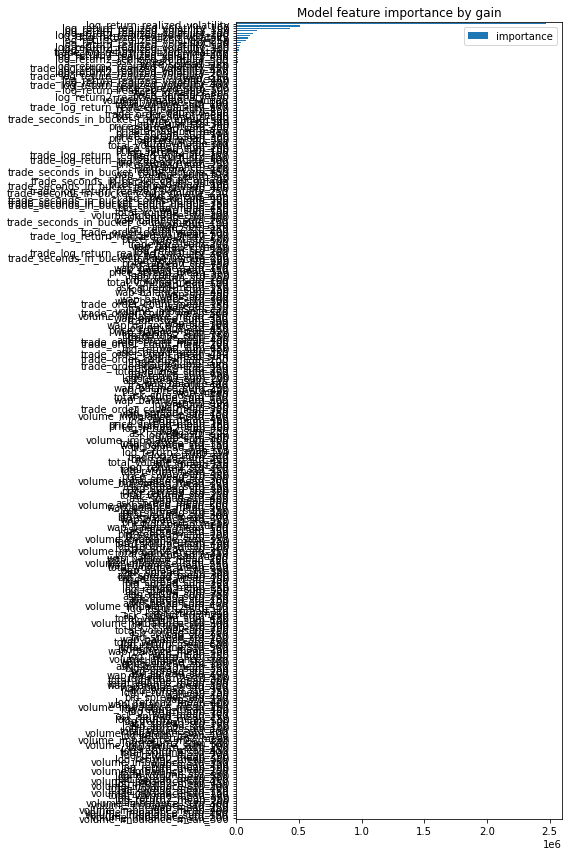

In [35]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

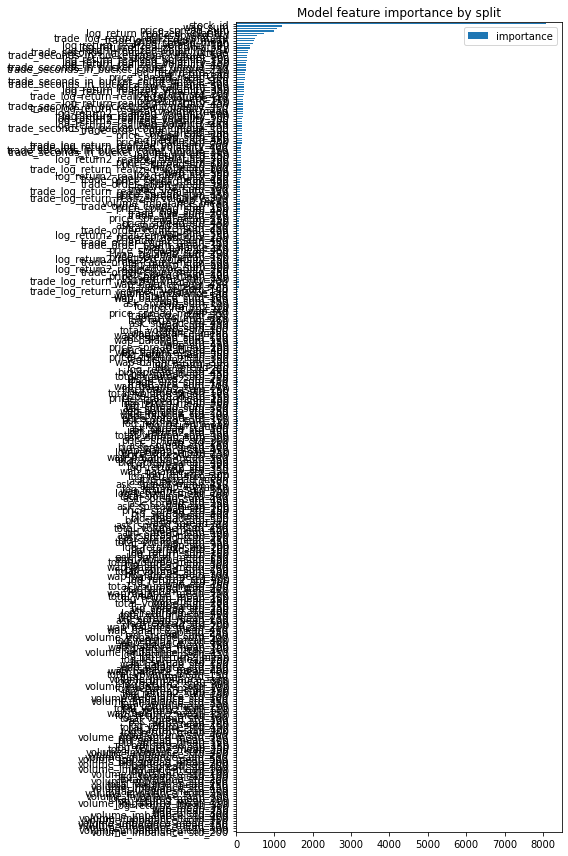

In [36]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)

In [37]:
df_test.columns

Index(['stock_id', 'time_id', 'row_id', 'log_return_realized_volatility',
       'log_return_mean', 'log_return_std', 'log_return_sum',
       'log_return2_realized_volatility', 'log_return2_mean',
       'log_return2_std',
       ...
       'trade_order_count_mean_200',
       'trade_log_return_realized_volatility_150',
       'trade_seconds_in_bucket_count_unique_150', 'trade_size_sum_150',
       'trade_order_count_mean_150',
       'trade_log_return_realized_volatility_100',
       'trade_seconds_in_bucket_count_unique_100', 'trade_size_sum_100',
       'trade_order_count_mean_100', 'stock_id_target_enc'],
      dtype='object', length=334)

In [38]:
df_train.columns

Index(['row_id', 'target', 'log_return_realized_volatility', 'log_return_mean',
       'log_return_std', 'log_return_sum', 'log_return2_realized_volatility',
       'log_return2_mean', 'log_return2_std', 'log_return2_sum',
       ...
       'trade_log_return_realized_volatility_150',
       'trade_seconds_in_bucket_count_unique_150', 'trade_size_sum_150',
       'trade_order_count_mean_150',
       'trade_log_return_realized_volatility_100',
       'trade_seconds_in_bucket_count_unique_100', 'trade_size_sum_100',
       'trade_order_count_mean_100', 'stock_id', 'stock_id_target_enc'],
      dtype='object', length=334)

In [39]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['time_id', 'row_id'], axis=1)
X_test

,stock_id,log_return_realized_volatility,log_return_mean,log_return_std,log_return_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return2_sum,wap_balance_mean,wap_balance_std,wap_balance_sum,price_spread_mean,price_spread_std,price_spread_sum,bid_spread_mean,bid_spread_std,bid_spread_sum,ask_spread_mean,ask_spread_std,ask_spread_sum,volume_imbalance_mean,volume_imbalance_std,volume_imbalance_sum,total_volume_mean,total_volume_std,total_volume_sum,wap_mean,wap_std,wap_sum,log_return_realized_volatility_500,log_return_mean_500,log_return_std_500,log_return_sum_500,log_return2_realized_volatility_500,log_return2_mean_500,log_return2_std_500,log_return2_sum_500,wap_balance_mean_500,wap_balance_std_500,wap_balance_sum_500,price_spread_mean_500,price_spread_std_500,price_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,bid_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,ask_spread_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,volume_imbalance_sum_500,total_volume_mean_500,total_volume_std_500,total_volume_sum_500,wap_mean_500,wap_std_500,wap_sum_500,log_return_realized_volatility_450,log_return_mean_450,log_return_std_450,log_return_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return2_sum_450,wap_balance_mean_450,wap_balance_std_450,wap_balance_sum_450,price_spread_mean_450,price_spread_std_450,price_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,bid_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,ask_spread_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,volume_imbalance_sum_450,total_volume_mean_450,total_volume_std_450,total_volume_sum_450,wap_mean_450,wap_std_450,wap_sum_450,log_return_realized_volatility_400,log_return_mean_400,log_return_std_400,log_return_sum_400,log_return2_realized_volatility_400,log_return2_mean_400,log_return2_std_400,log_return2_sum_400,wap_balance_mean_400,wap_balance_std_400,wap_balance_sum_400,price_spread_mean_400,price_spread_std_400,price_spread_sum_400,bid_spread_mean_400,bid_spread_std_400,bid_spread_sum_400,ask_spread_mean_400,ask_spread_std_400,ask_spread_sum_400,volume_imbalance_mean_400,volume_imbalance_std_400,volume_imbalance_sum_400,total_volume_mean_400,total_volume_std_400,total_volume_sum_400,wap_mean_400,wap_std_400,wap_sum_400,log_return_realized_volatility_350,log_return_mean_350,log_return_std_350,log_return_sum_350,log_return2_realized_volatility_350,log_return2_mean_350,log_return2_std_350,log_return2_sum_350,wap_balance_mean_350,wap_balance_std_350,wap_balance_sum_350,price_spread_mean_350,price_spread_std_350,price_spread_sum_350,bid_spread_mean_350,bid_spread_std_350,bid_spread_sum_350,ask_spread_mean_350,ask_spread_std_350,ask_spread_sum_350,volume_imbalance_mean_350,volume_imbalance_std_350,volume_imbalance_sum_350,total_volume_mean_350,total_volume_std_350,total_volume_sum_350,wap_mean_350,wap_std_350,wap_sum_350,log_return_realized_volatility_300,log_return_mean_300,log_return_std_300,log_return_sum_300,...,log_return2_sum_250,wap_balance_mean_250,wap_balance_std_250,wap_balance_sum_250,price_spread_mean_250,price_spread_std_250,price_spread_sum_250,bid_spread_mean_250,bid_spread_std_250,bid_spread_sum_250,ask_spread_mean_250,ask_spread_std_250,ask_spread_sum_250,volume_imbalance_mean_250,volume_imbalance_std_250,volume_imbalance_sum_250,total_volume_mean_250,total_volume_std_250,total_volume_sum_250,wap_mean_250,wap_std_250,wap_sum_250,log_return_realized_volatility_200,log_return_mean_200,log_return_std_200,log_return_sum_200,log_return2_realized_volatility_200,log_return2_mean_200,log_return2_std_200,log_return2_sum_200,wap_balance_mean_200,wap_balance_std_200,wap_balance_sum_200,price_spread_mean_200,price_spread_std_200,price_spread_sum_200,bid_spread_mean_200,bid_spread_std_200,bid_spread_sum_200,ask_spread_mean_200,ask_spread_std_200,ask_spread_sum_200,volume_imbalance_mean_200,volume_imbalance_std_200,volume_imbalance_sum_200,total_volume_mean_200,to

In [40]:
target = np.zeros(len(X_test))
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)
    
y_pred = y_pred.assign(target=target)
y_pred

,row_id,target
0,0-4,0.001462
1,0-32,0.001465
2,0-34,0.001465


In [41]:
y_pred.to_csv('submission.csv',index = False)